# Simulation of Complex Systems - Chapter 13
**Author**: Artur Gasparyan

In [20]:
import numpy as np
import matplotlib.pyplot as plt

seed = 69420
rng = np.random.default_rng(seed)

## Exercise 13.1

In [87]:
def get_outcomes(T, R, P, S):
    # Betray = 0
    # Cooperate = 1

    # 0,0 -> P,P
    # 0,1 -> T,S
    # 1,0 -> S,T
    # 1,1 -> R,R
    
    return np.array([
        [[P, P], [T, S]],
        [[S, T], [R, R]]
    ])

In [88]:
def get_years(N, outcomes):
    years_all = np.zeros((N, N, N, 2))

    for n in range(N):
        for m in range(N):
            d1 = np.ones(N, dtype=int)
            d2 = np.ones(N, dtype=int)
            if n < m:
                d1[n:] = 0
                d2[n+1:] = 0
            elif n > m:
                d1[m+1:] = 0
                d2[m:] = 0
            else:
                d1[m:]= 0
                d2[m:]= 0

            outcome = outcomes[d1, d2]
            years_all[n, m, :, :] = outcome
            
    return years_all

In [93]:
N = 10
T = 0
R = 0.5
P = 1
S = 1.5

outcomes = get_outcomes(T, R, P, S)
years_all = get_years(N, outcomes)

In [94]:
def plot_1d(years_all, fig, ax):
    years = years_all[:, 6, :, 0]
    acc_years = np.sum(years, axis=1)
    ax.scatter(np.arange(N), acc_years)
    ax.axvline(6, c='red')
    ax.legend(["outcome", "m"])
    ax.set_ylim(5, 10)
    ax.set_xlabel('n')
    ax.set_ylabel('years')


In [95]:
def plot_2d(years_all, fig, ax):
    years = years_all[:, :, :, 0]
    acc_years = np.sum(years, axis=2)
    im = ax.imshow(acc_years, origin='lower')
    ax.plot(np.arange(1, N), np.arange(N-1), linestyle='--', c='white')
    fig.colorbar(im, ax=ax, label='prison years')
    ax.set_xlabel('m')
    ax.set_ylabel('n')
    ax.legend(["n = m - 1"])

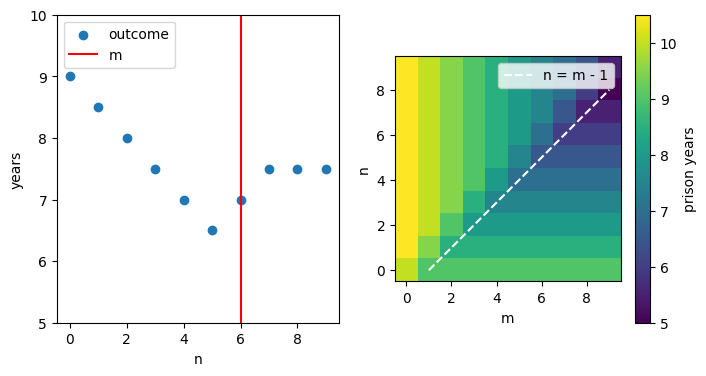

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plot_1d(years_all, fig=fig, ax=ax1)
plot_2d(years_all, fig=fig, ax=ax2)


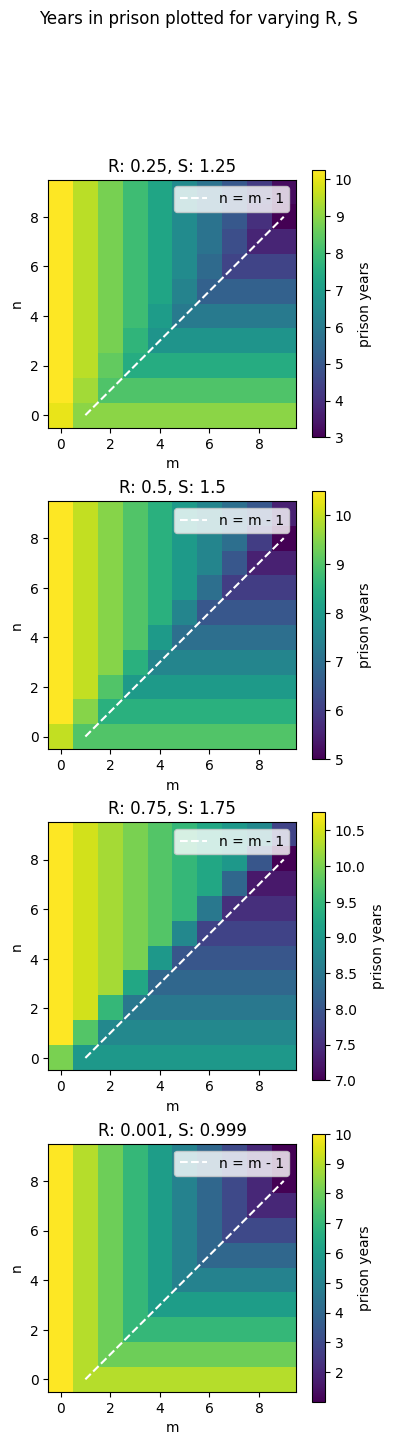

In [98]:
N = 10
T = 0
P = 1

Rs = [0.25, 0.5, 0.75, 0.001]
Ss = [1.25, 1.5, 1.75, 0.999]
n_plots = len(Rs)

fig, axes = plt.subplots(n_plots, 1, figsize=(4, 4*n_plots))
fig.suptitle("Years in prison plotted for varying R, S")

for i in range(n_plots):
    R = Rs[i]
    S = Ss[i]
    ax = axes[i]
    ax.set_title(f'R: {R}, S: {S}')
    
    outcomes = get_outcomes(T, R, P, S)
    years_all = get_years(N, outcomes)
    plot_2d(years_all, fig, ax)
    
    